In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import glob

path = "/Users/gadzhiev-im/Documents/projects/kp_experiments/*24*/report/report.xlsx"
experiments = glob.glob(path)

In [4]:
experiments

['/Users/gadzhiev-im/Documents/projects/kp_experiments/result_24c_8/report/report.xlsx',
 '/Users/gadzhiev-im/Documents/projects/kp_experiments/result_24c/report/report.xlsx']

In [5]:
report = pd.read_excel(experiments[1], index_col=0)

In [7]:
dim = {
    'cv_catboost': "TSS CatBoost",
    'cv_lightgbm': "TSS LightGBM",
    "cv_lr": "TSS LR",
    "cv_nn_perceptron": "TSS Perceptron",
    "cv_randomforest": "TSS RF",
    "cv_smote_lr": "TSS SMOTE LR",
    "cv_smote_randomforest": "TSS SMOTE RF",
    "cv_smote_ridge": "TSS SMORE Ridge",
    "cv_xgboost": "TSS XGBoost",
    "catboost": "CatBoost",
    "lightgbm": "LightGBM",
    "lr": "LR",
    "nn_perceptron": "Perceptron",
    "randomforest": "RF",
    "ridge": "Ridge",
    "cv_ridge": "TSS Ridge",
    "smote_catboost": "SMOTE CatBoost",
    "smote_lightgbm": "SMOTE LightGBM",
    "cv_smote_catboost": "TSS SMOTE CatBoost",
    "cv_smote_lightgbm": "TSS SMOTE LightGBM",
    "smote_lr": "SMOTE LR",
    "smote_randomforest": "SMOTE RF",
    "smote_ridge": "SMOTE Ridge",
    "xgboost": "XGBoost",
    "columnestimator": "TM",
    "nn_gru": "GRU",
    "nn_lstm": "LSTM",
}

In [8]:

def process_report(report, mode=0):
    report = report.copy()
    report.columns = report.columns.str.extract('run_(.+)_f1', expand=False)
    report = report.sort_index(axis=1).T
    if mode == 0:
        cv = report.index[report.index.str.contains('cv_')]
        report = pd.concat([
            report.loc[cv], 
            report.drop(cv.values.tolist() + ['columnestimator'], errors=False), 
            report.loc[['columnestimator']]])
    else:
        return report
    return report

def map_color(x):
    
    codes = {
        'b': "#90D4F6",
        'g': '#80FF7C',
        'r': '#FDA8A2'
    }

    def _map(x):
        if x == 'TM':
            return codes['g']
        if x == 'dummy':
            return codes['b']
        else:
            return codes['b']
    colors = list(map(_map, x.index))
    argmax = x.values.argmax()
    if colors[argmax] != codes['g']:
        colors[argmax] = codes['r']
    
    return colors

def draw_scores(ax, scores, min_score, score_font):
    for i, score in enumerate(scores):
        ax.text(
            x=max(score / 1.5, min_score), y=i - .1, s=f'{100 * score:.1f}',
            fontdict=score_font
        )

def plot_report(
    report, min_x=.3, max_x=.75, labelsize=14,
    score_font={'size': 16, "weight": "bold"}):

    f, ax = plt.subplots(nrows=1, ncols=report.shape[1], sharey=True)


    for i in report.columns:
        colors = map_color(report[i])
        report[i].plot.barh(ax=ax[i], color=colors)
        ax[i].axvline(report[i]['TM'], color='g', ls='--')
        ax[i].set_xlim(min_x, max_x)
        ax[i].grid()
        ax[i].set_title(f'Горизонт {i + 1}')
        draw_scores(ax[i], (report[i].values).tolist(), min_x + .02, score_font)

    f.set_figheight(len(report) * .6)
    f.set_figwidth(report.shape[1] * 2)
    ax[0].tick_params(axis='y', which='major', labelsize=labelsize)
    plt.tight_layout()
    
    return f, ax

def draw_scores1(ax, scores, min_score, score_font):
    for i, score in enumerate(scores):
        ax.text(
            y=max(score / 1.2, min_score), x=i - .1, s=f'{100 * score:.1f}',
            fontdict=score_font
        )
        
def plot_report1(
    report, min_y=.3, max_y=.75, labelsize=14,
    score_font={'size': 16, "weight": "bold"},
    ycoef=.6, xcoef=1.8
    ):

    f, ax = plt.subplots(nrows=report.shape[1], ncols=1, sharex=True)


    for i in report.columns:
        colors = map_color(report[i])
        report[i].plot.bar(ax=ax[i], color=colors)
        ax[i].axvline(report[i]['TM'], color='g', ls='--')
        ax[i].set_ylim(min_y, max_y)
        ax[i].grid()
        ax[i].set_title(f'{(i + 1) * 3} ч.\nвперед', fontdict={"size": 18})
        draw_scores1(ax[i], (report[i].values).tolist(), min_y + .02, score_font)
        ax[i].tick_params(axis='y', which='major', labelsize=labelsize)

    f.set_figheight(report.shape[1] * ycoef)
    f.set_figwidth(len(report) * xcoef)
    ax[-1].tick_params(axis='x', which='major', labelsize=labelsize)
    plt.tight_layout()
    
    return f, ax

In [9]:
df = process_report(report).drop("dummy").drop("cv_dummy").drop("xgboost").drop("cv_xgboost")


In [10]:
mask_cv = df.index.str.contains("cv")
mask_smote = df.index.str.contains("smote")
mask_column = df.index.str.contains("column")
df.index = pd.Series(df.index).replace(dim).values

In [11]:
mask1 = ~(mask_cv | mask_smote)

In [12]:
import matplotlib as mpl


def plot_report_op(report):

    cmap = plt.cm.Greys  # define the colormap
    # extract all colors from the .jet map
    cmaplist = list(reversed([cmap(i) for i in range(cmap.N)]))[: -80]
    # force the first color entry to be grey

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, len(cmaplist))

    plot_data = report.T.copy()
    plot_data.index = list(map(lambda x: f'{(x + 1)* 3} ч', plot_data.index))

    ax = plot_data.plot.bar(figsize=(10, 4), cmap=cmap, edgecolor='white', linewidth=1, width=.8)

    plt.legend(
        title="Модель",
        bbox_to_anchor=(1, 1), fancybox=True, fontsize=14, )
    
    plt.grid()
    plt.xticks(rotation=0, fontsize=14)
    plt.xlabel("Горизонт прогнозирования", fontdict={"size": 15})
    plt.ylabel("$F_1$", fontdict={"size": 15})
    

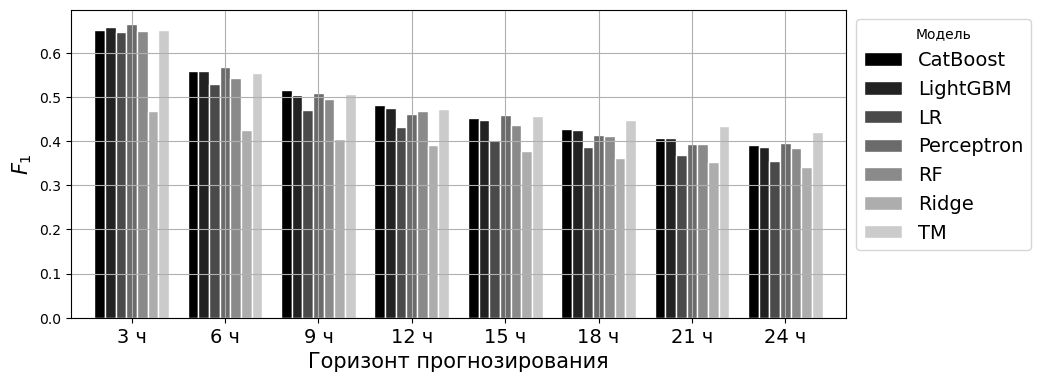

In [13]:
mask1 = ~(mask_cv | mask_smote)
plot_report_op(
    df[mask1]
)

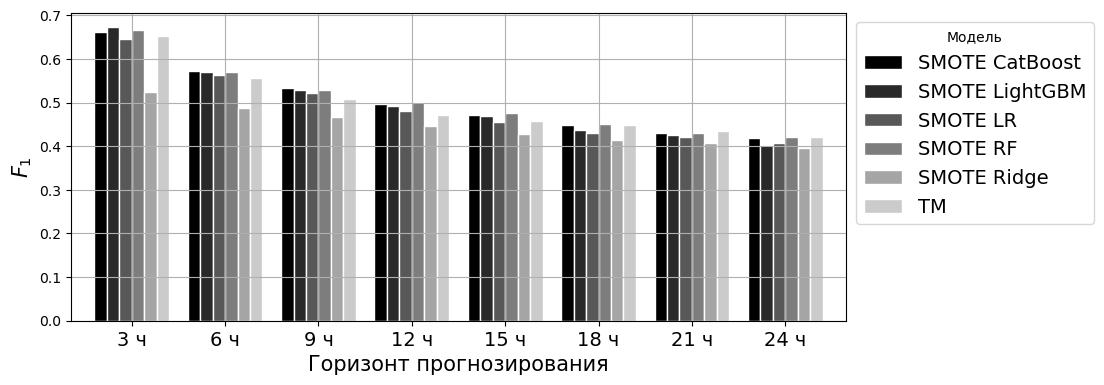

In [14]:
mask1 = ~mask_cv & (mask_column | mask_smote)
plot_report_op(
    df[mask1]
)

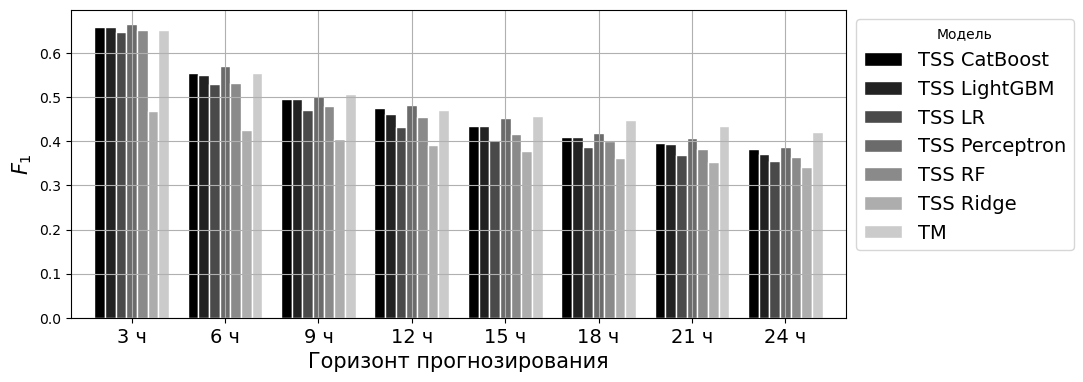

In [15]:
mask1 = ~mask_smote & (mask_column | mask_cv)

plot_report_op(df[mask1])

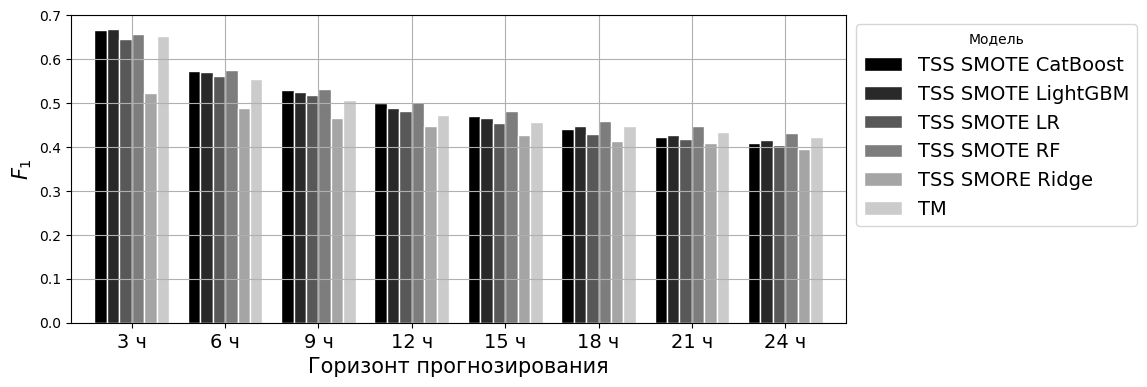

In [16]:
mask1 = (mask_smote & mask_cv) | mask_column
plot_report_op(df[mask1])

In [20]:
report_old = pd.read_excel(
    "/Users/gadzhiev-im/Documents/projects/kp_experiments/result/report/report.xlsx",
    index_col=0)

In [26]:
(report - report_old).mean(axis=1)

0   -0.004326
1   -0.004379
2   -0.001559
3   -0.001566
4   -0.003213
5   -0.007856
6   -0.007968
7   -0.010783
dtype: float64

In [29]:
report1 = pd.read_excel(
    "/Users/gadzhiev-im/Documents/projects/kp_experiments/result_24c_8/report/report.xlsx",
    index_col=0)

report_old1 = pd.read_excel(
    "/Users/gadzhiev-im/Documents/projects/kp_experiments/result_8/report/report.xlsx",
    index_col=0)

In [32]:
(report1 - report_old1 ).mean(axis=1)

0   -0.006621
1   -0.004292
2   -0.005501
3   -0.005083
4   -0.008279
5   -0.008674
6   -0.008844
7   -0.010187
dtype: float64

In [33]:
report = pd.read_excel(experiments[0], index_col=0)
df = process_report(report).drop("dummy").drop("cv_dummy").drop("xgboost").drop("cv_xgboost")
mask_cv = df.index.str.contains("cv")
mask_smote = df.index.str.contains("smote")
mask_column = df.index.str.contains("column")
df.index = pd.Series(df.index).replace(dim).values

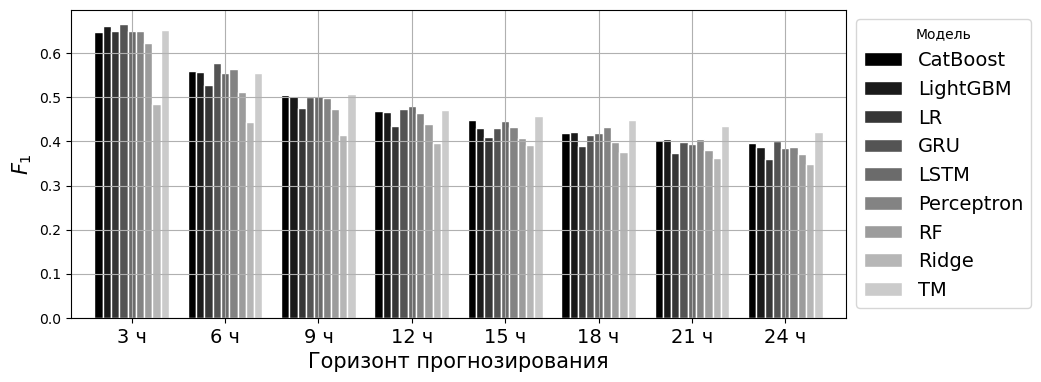

In [34]:
mask1 = ~(mask_cv | mask_smote)
plot_report_op(
    df[mask1]
)

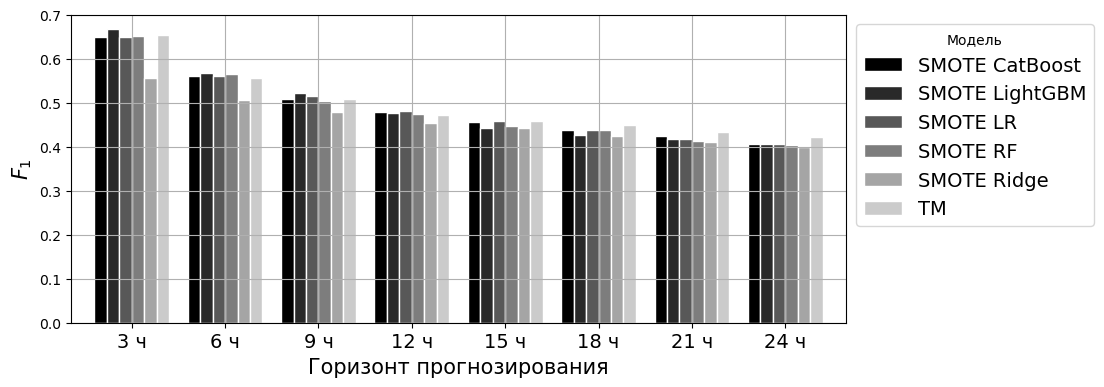

In [35]:
mask1 = ~mask_cv & (mask_column | mask_smote)
plot_report_op(
    df[mask1]
)

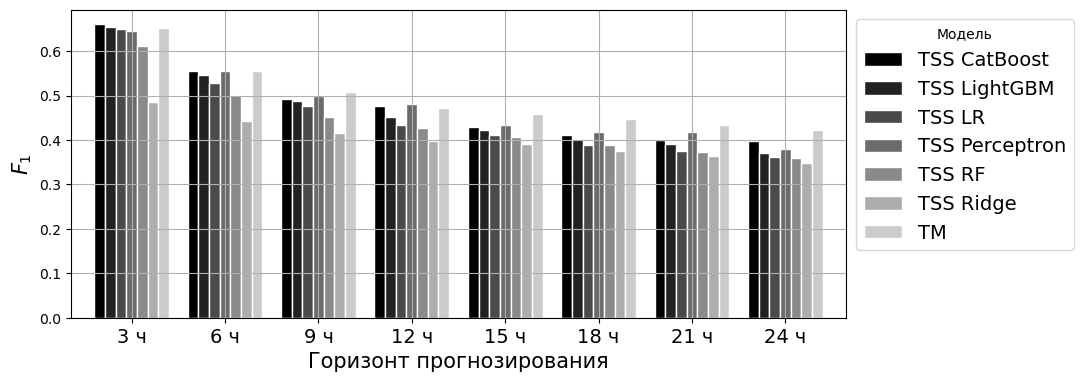

In [36]:
mask1 = ~mask_smote & (mask_column | mask_cv)

plot_report_op(df[mask1])

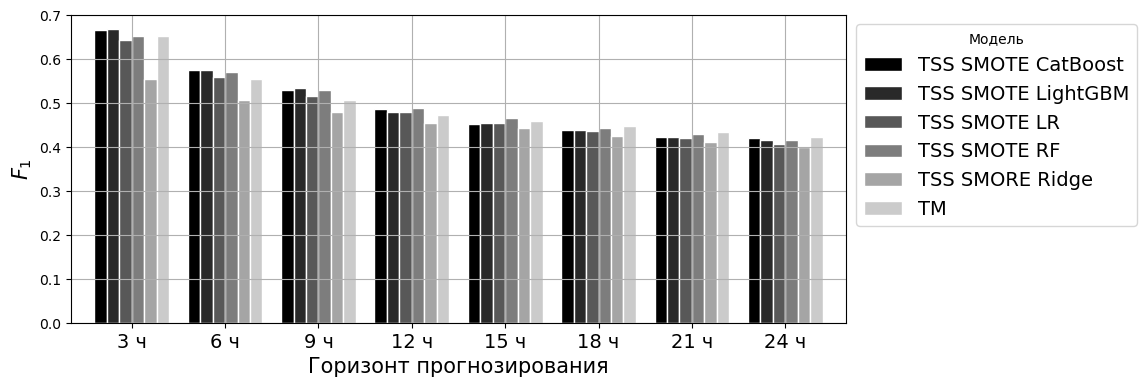

In [37]:
mask1 = (mask_smote & mask_cv) | mask_column
plot_report_op(df[mask1])

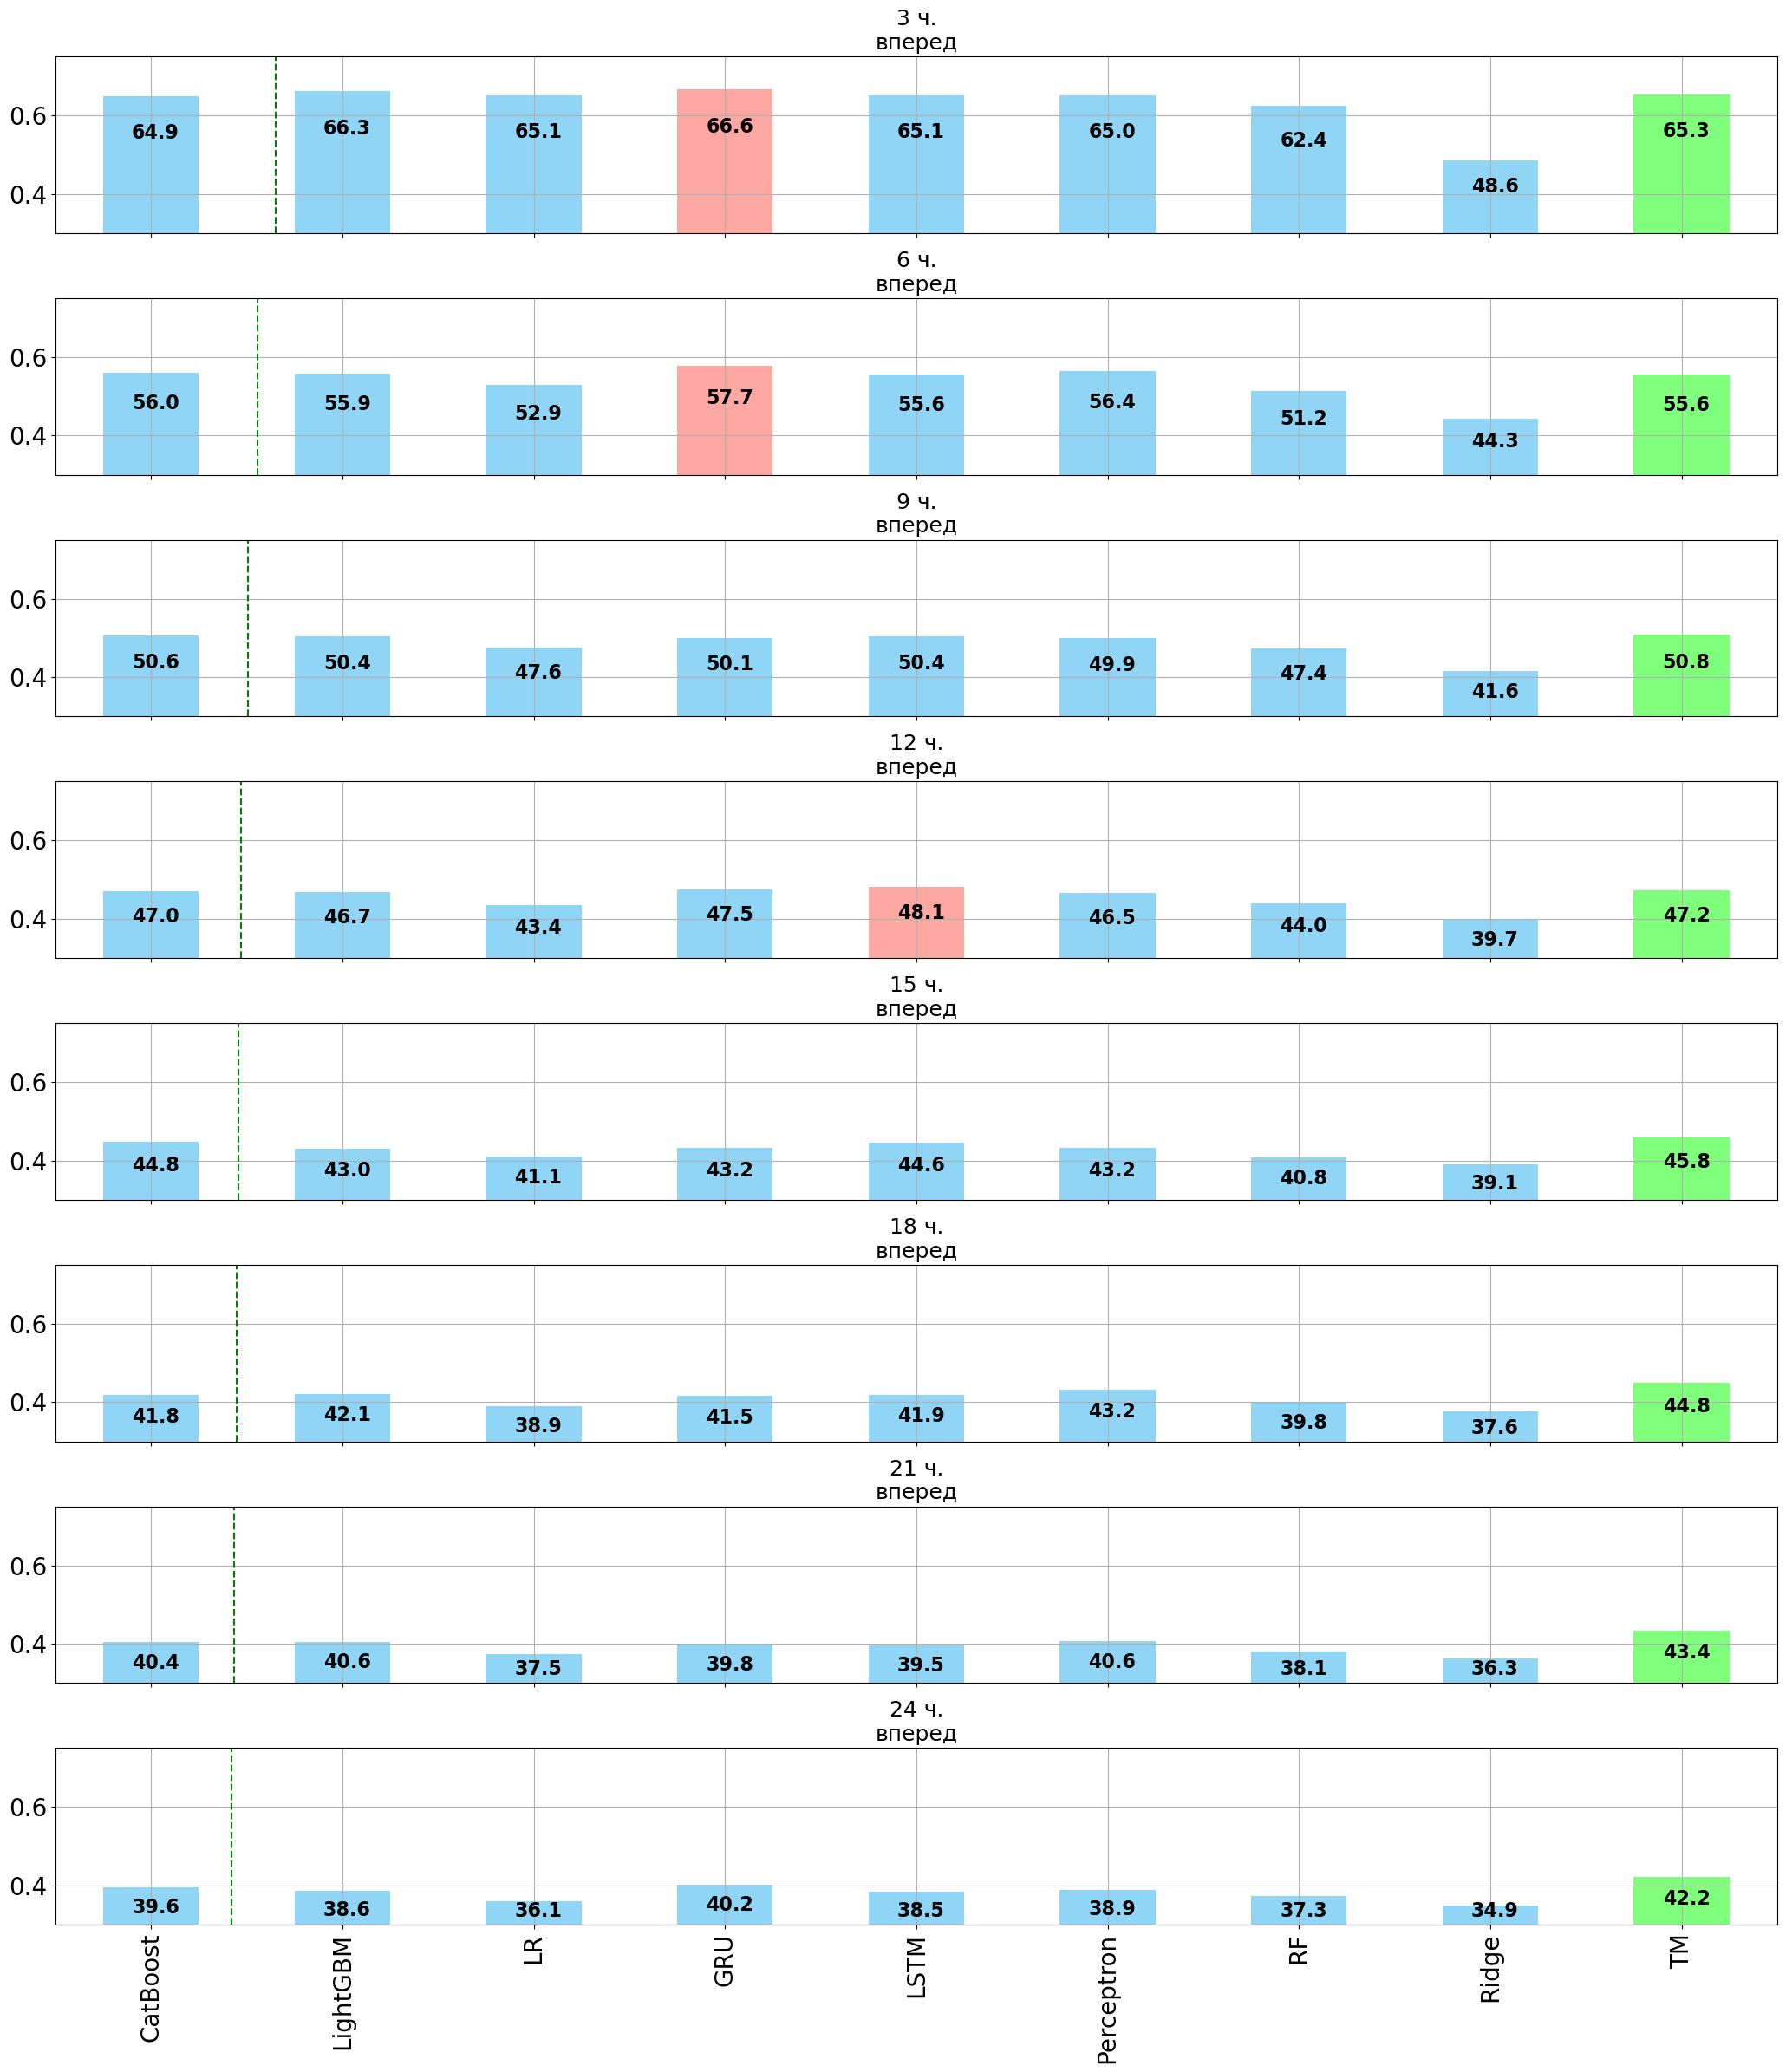

In [38]:
mask1 = ~(mask_cv | mask_smote)

f, ax = plot_report1(df[mask1], min_y=.3, labelsize=20, ycoef=3, xcoef=2.3)

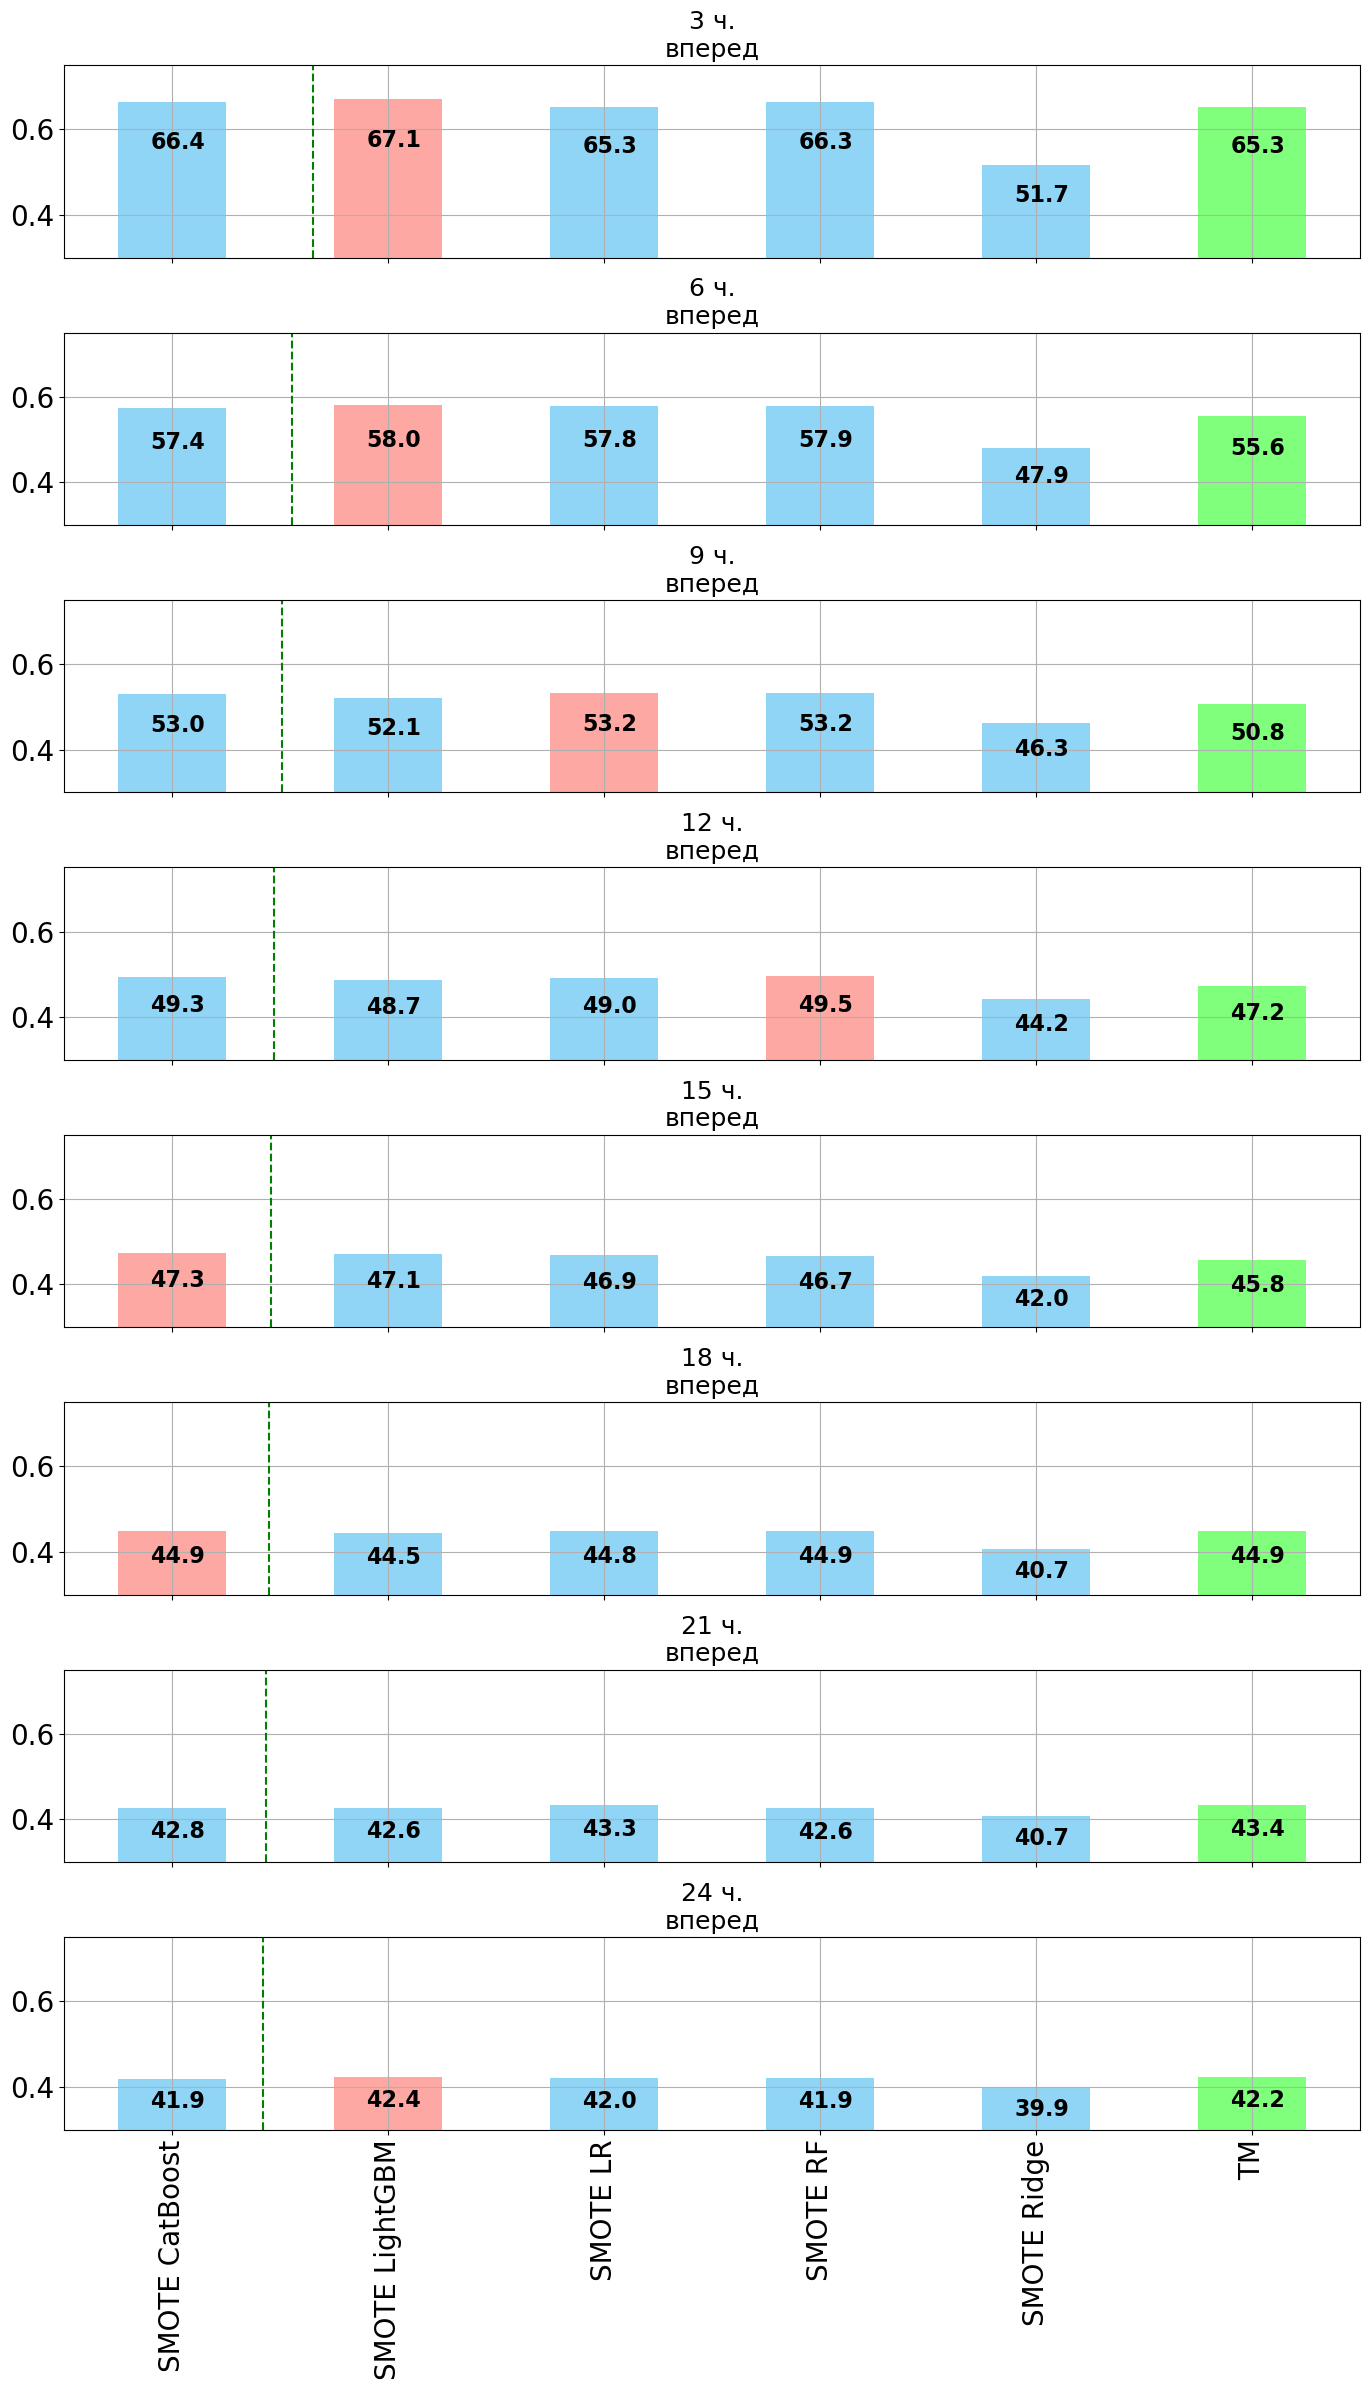

In [39]:
mask1 = ~mask_cv & (mask_column | mask_smote)

f, ax = plot_report1(df[mask1], labelsize=20, ycoef=3, xcoef=2.3)

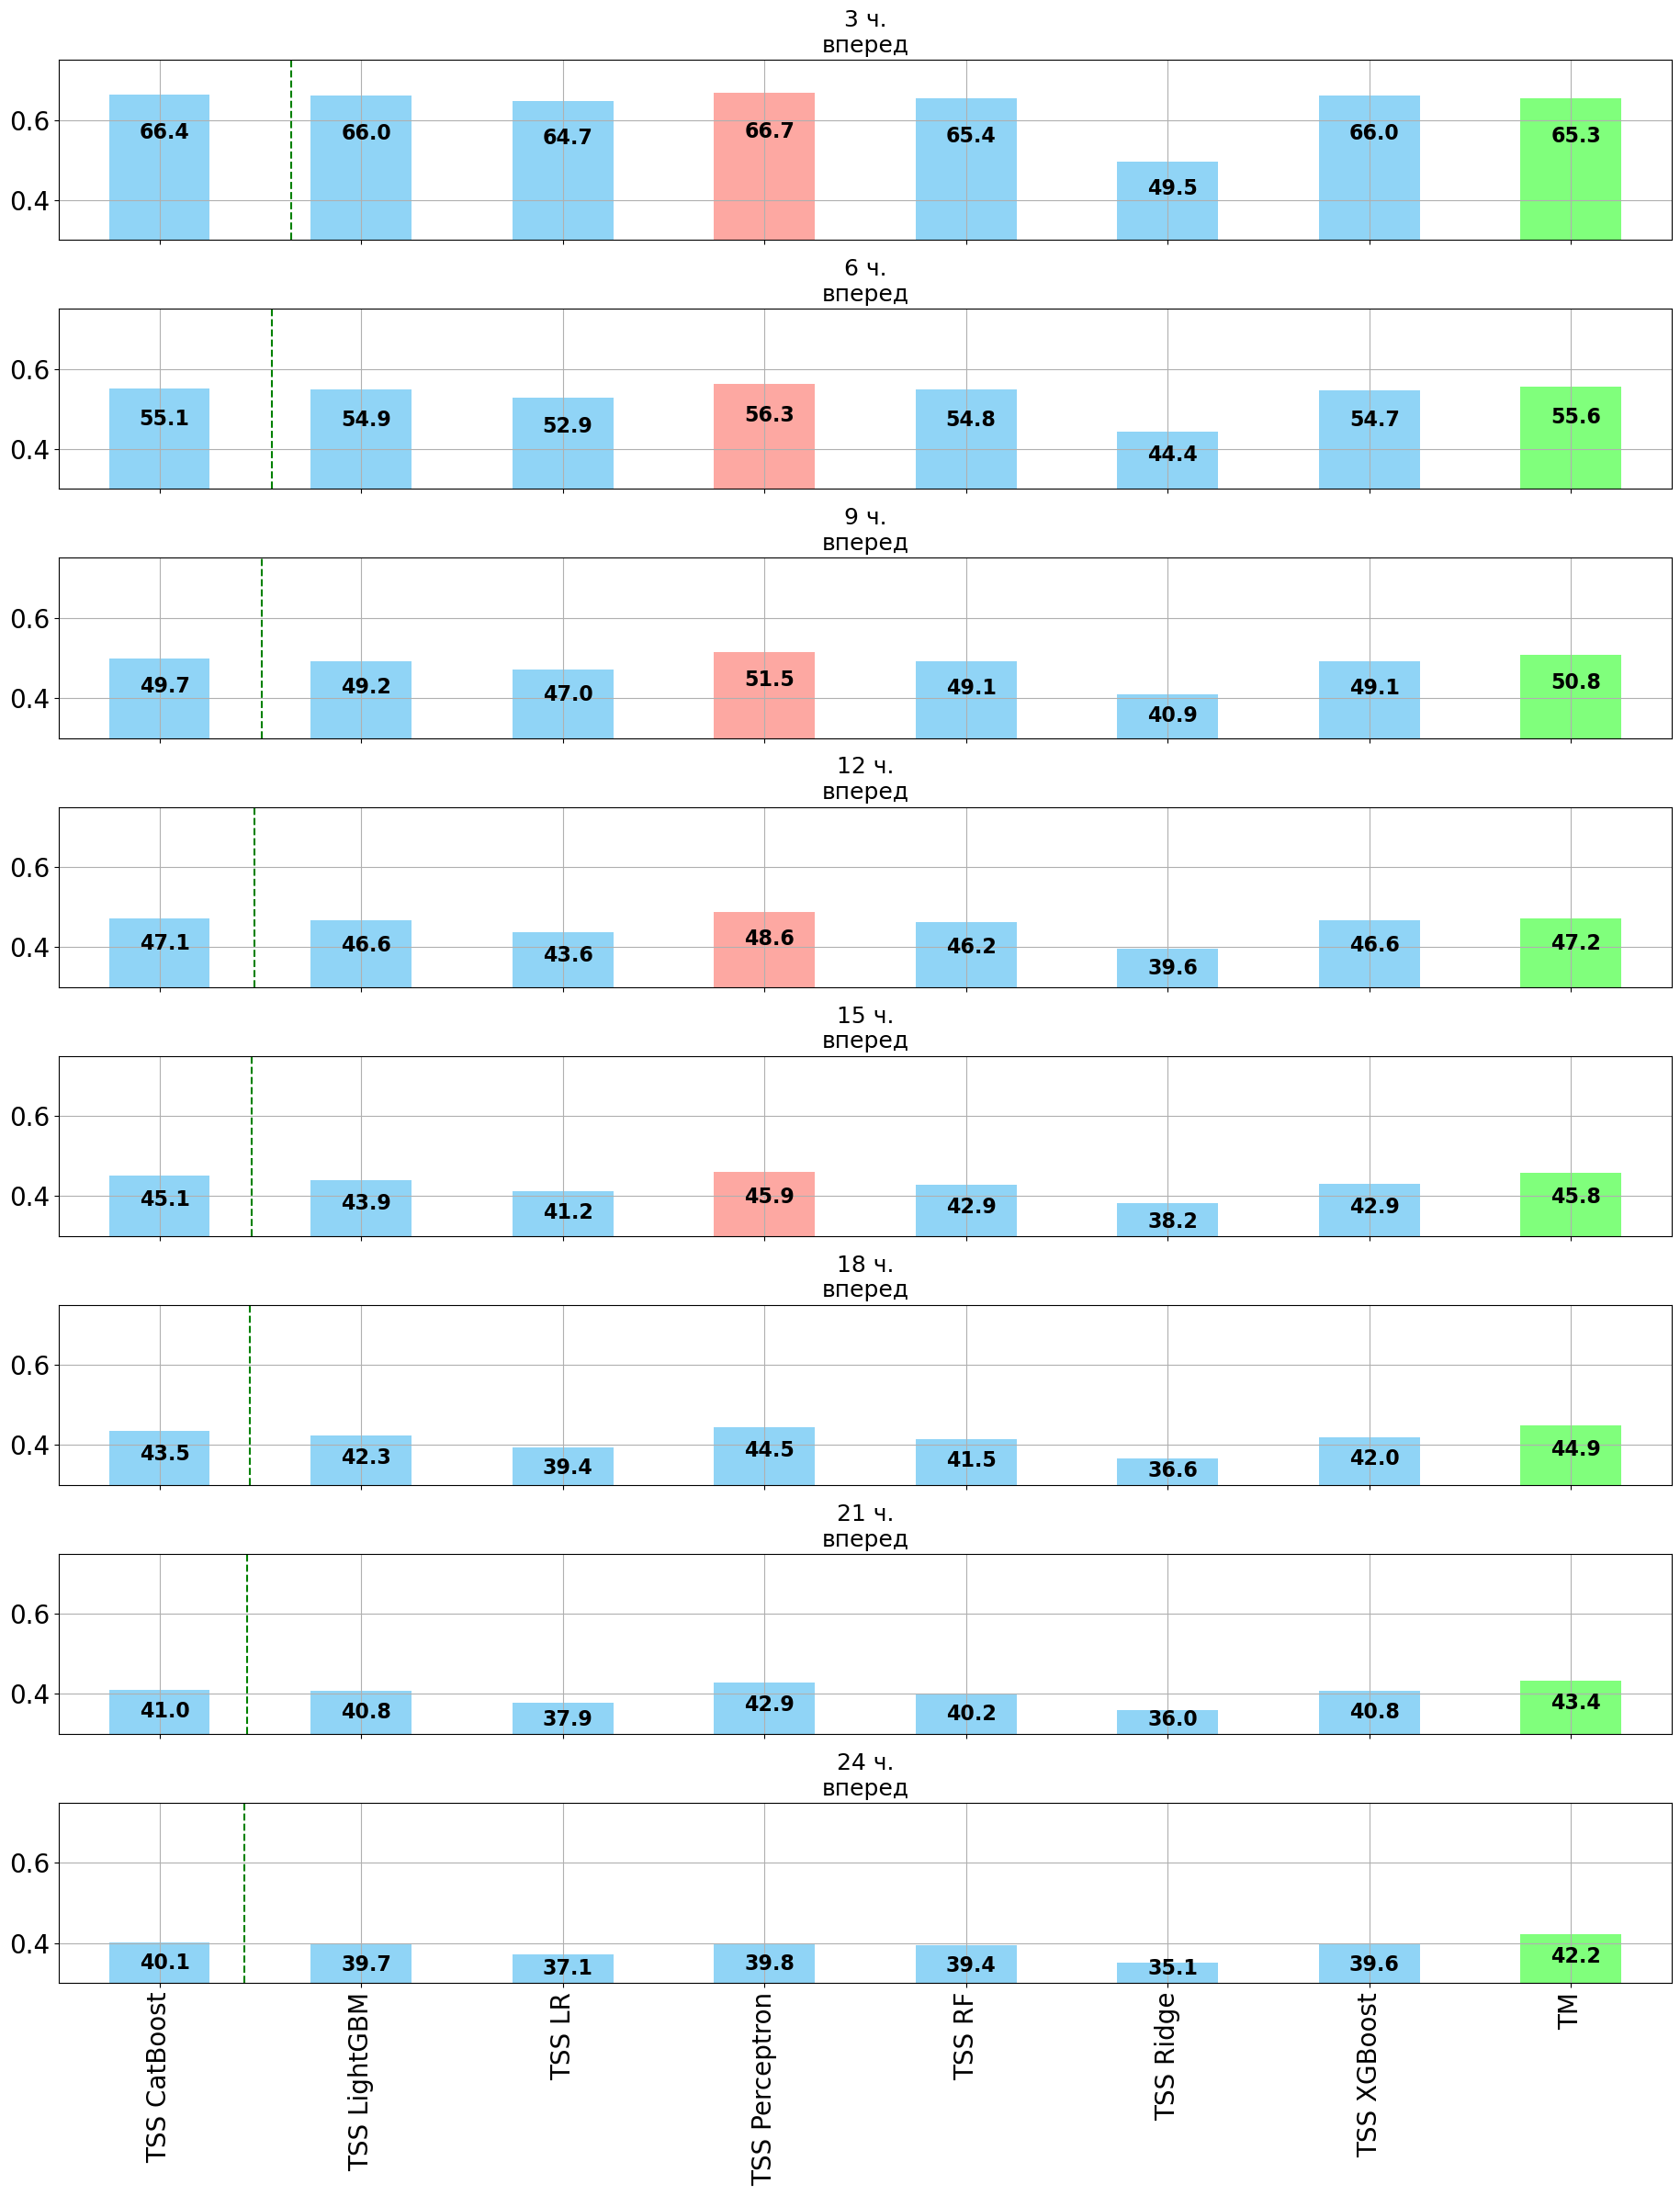

In [40]:
mask1 = ~mask_smote & (mask_column | mask_cv)

f, ax = plot_report1(df[mask1], labelsize=20, ycoef=3, xcoef=2.3)

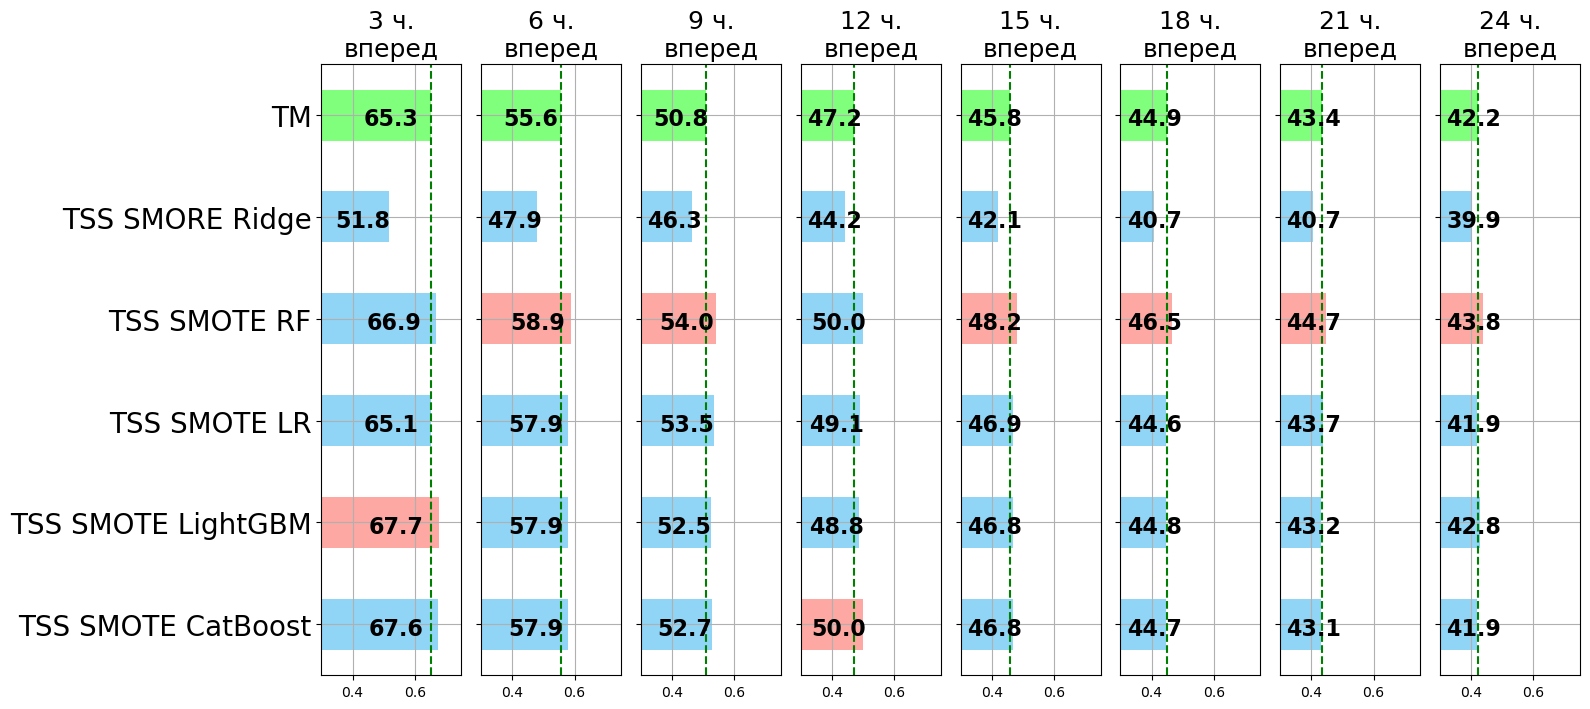

In [116]:
mask1 = (mask_smote & mask_cv) | mask_column
f, ax = plot_report(df[mask1], labelsize=20, ycoef=1.2, xcoef=2.)

In [117]:
report = pd.read_excel(experiments[1], index_col=0)
df = process_report(report).drop("dummy").drop("cv_dummy")
mask_cv = df.index.str.contains("cv")
mask_smote = df.index.str.contains("smote")
mask_column = df.index.str.contains("column")
df.index = pd.Series(df.index).replace(dim).values

In [118]:
mask_cv = df.index.str.contains("cv")
mask_smote = df.index.str.contains("smote")
mask_column = df.index.str.contains("column")
df.index = pd.Series(df.index).replace(dim).values

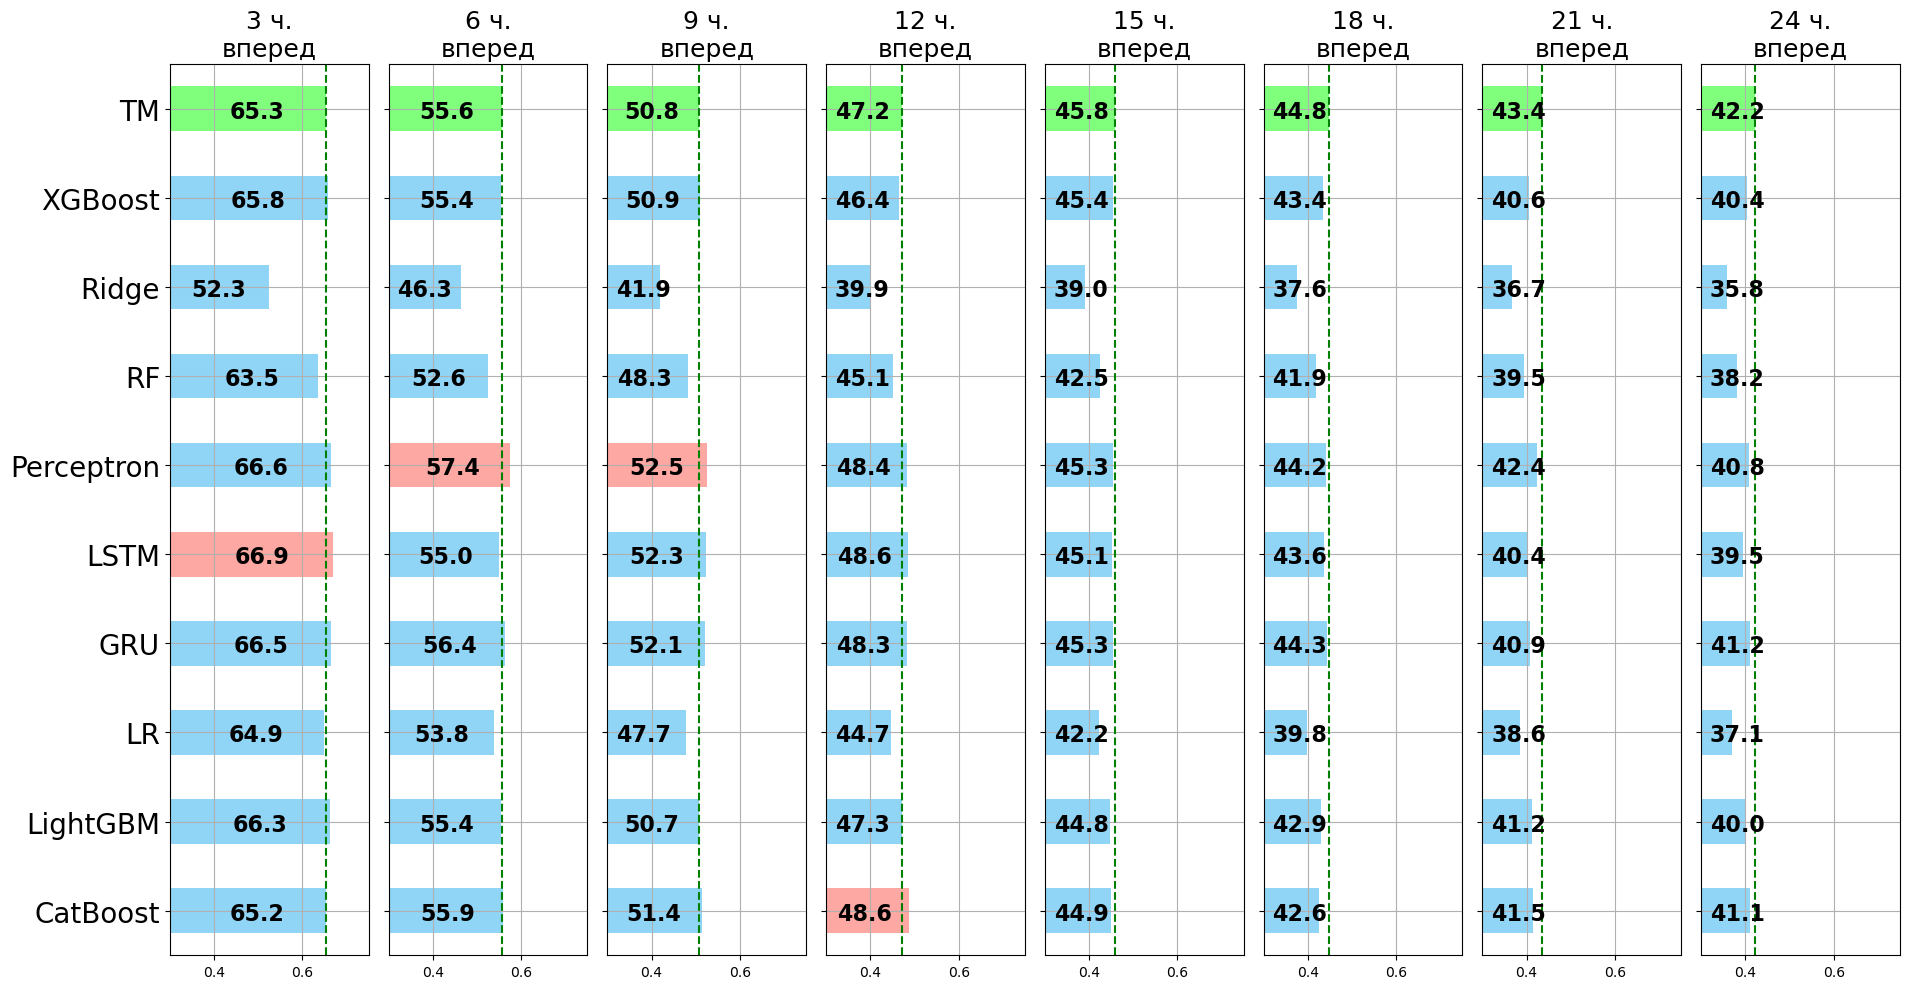

In [121]:
mask1 = ~(mask_cv | mask_smote)

f, ax = plot_report(df[mask1], min_x=.3, labelsize=20, ycoef=1, xcoef=2.4)

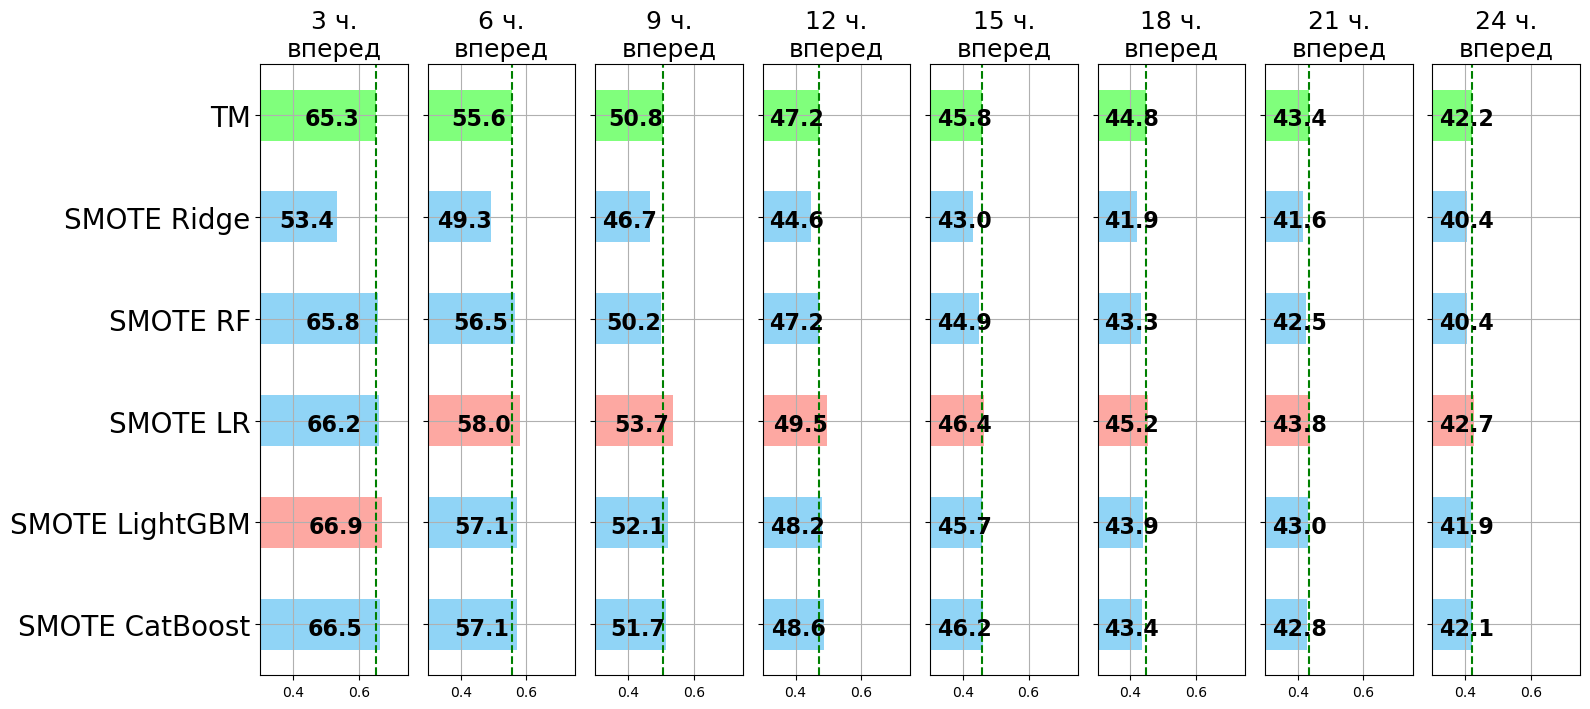

In [122]:
mask1 = ~mask_cv & (mask_column | mask_smote)

f, ax = plot_report(df[mask1], labelsize=20, ycoef=1.2, xcoef=2.)

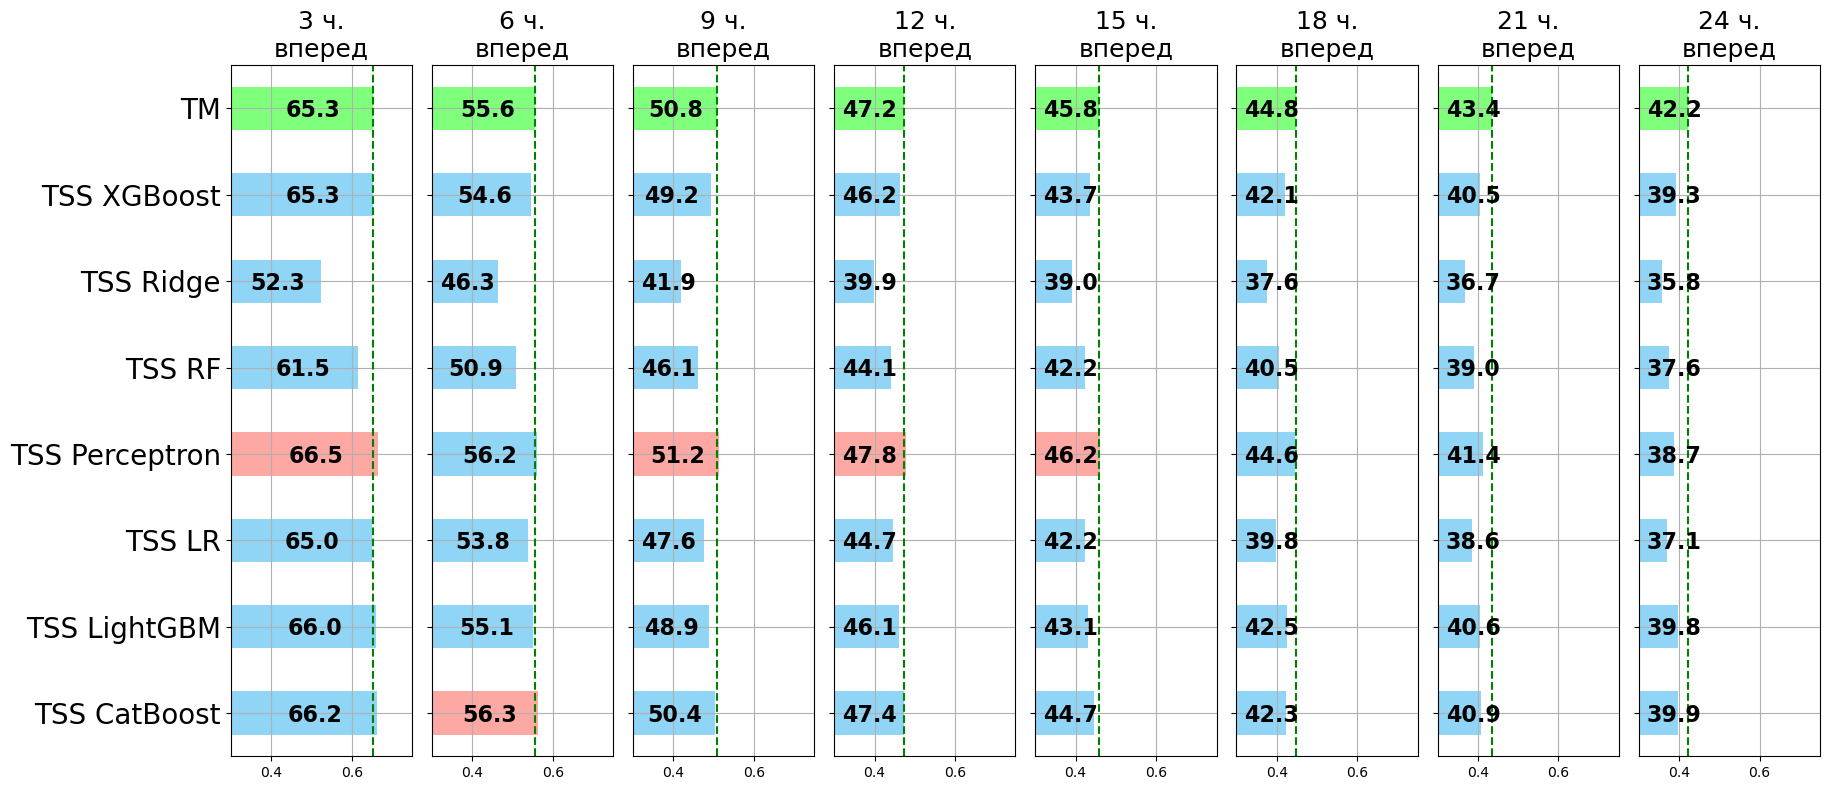

In [124]:
mask1 = ~mask_smote & (mask_column | mask_cv)

f, ax = plot_report(df[mask1], min_x=.3, labelsize=20, ycoef=1, xcoef=2.3)

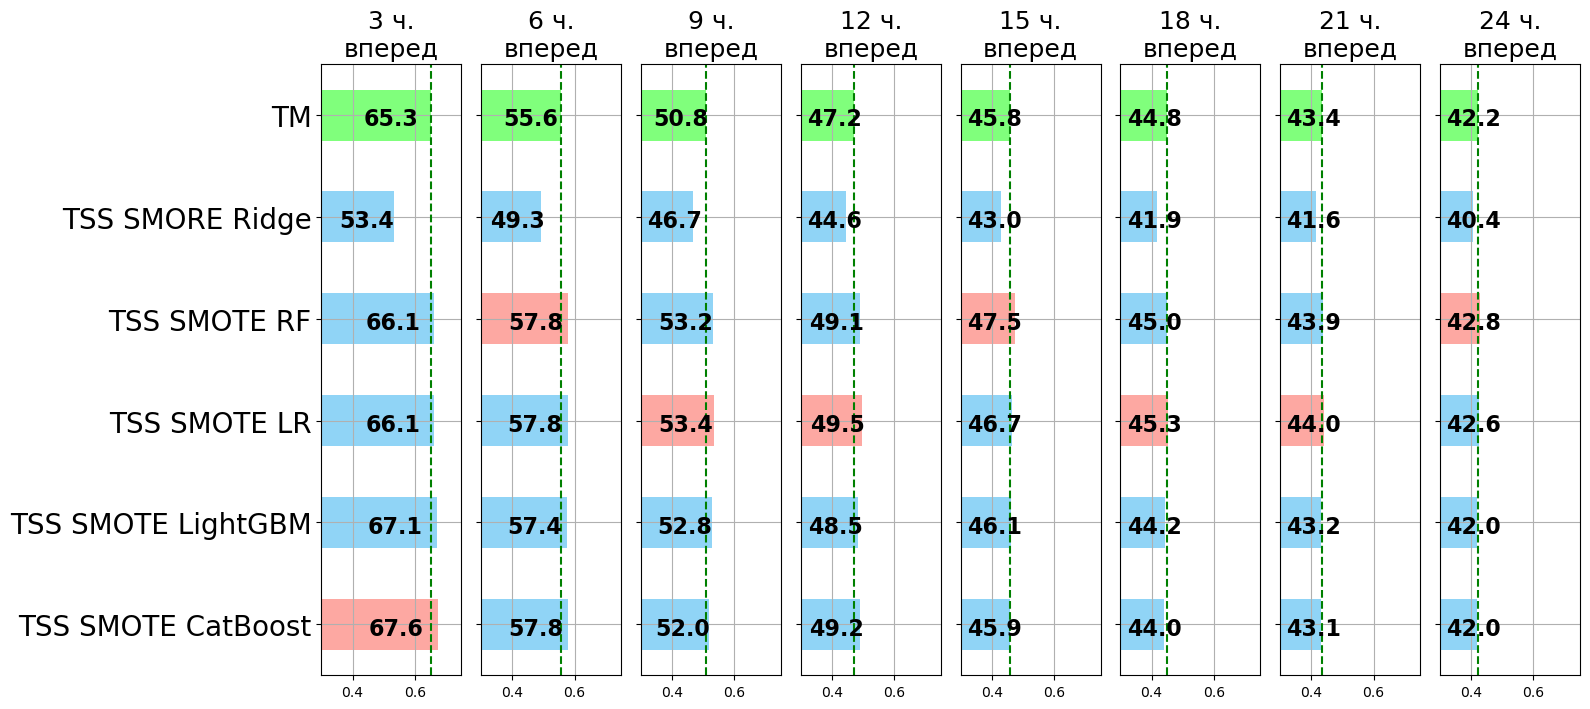

In [125]:
mask1 = (mask_smote & mask_cv) | mask_column
f, ax = plot_report(df[mask1], labelsize=20, ycoef=1.2, xcoef=2.)

In [105]:
df.idxmax()

0    TSS SMOTE CatBoost
1              SMOTE LR
2              SMOTE LR
3              SMOTE LR
4          TSS SMOTE RF
5          TSS SMOTE LR
6          TSS SMOTE LR
7          TSS SMOTE RF
dtype: object

In [106]:
df.max()

0    0.675646
1    0.580452
2    0.536685
3    0.495344
4    0.475041
5    0.452768
6    0.439933
7    0.428406
dtype: float64

In [115]:
df.max()

0    0.676870
1    0.588638
2    0.539766
3    0.500075
4    0.481798
5    0.465151
6    0.447478
7    0.438354
dtype: float64

In [114]:
df.idxmax()

0    TSS SMOTE LightGBM
1          TSS SMOTE RF
2          TSS SMOTE RF
3    TSS SMOTE CatBoost
4          TSS SMOTE RF
5          TSS SMOTE RF
6          TSS SMOTE RF
7          TSS SMOTE RF
dtype: object